In [1]:
%matplotlib inline

In [2]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import transforms

In [3]:
import sys
sys.path.append("..")
from dataset import GenderDataset
from model.gender import GenderNet

In [4]:
def setup_seed(seed):
    import os
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    torch.manual_seed(seed) # 为CPU设置随机种子
    torch.cuda.manual_seed_all(seed) # 为当前GPU设置随机种子
    torch.cuda.manual_seed_all(seed) # 为所有GPU设置随机种子
    np.random.seed(seed) # # Numpy设置随机种子
    random.seed(seed) # Python设置随机种子
    # torch.backends.cudnn.deterministic = True
    print('Setting up seed finished!')
    
setup_seed(1)

Setting up seed finished!


In [5]:
# Data
train_set = GenderDataset('data/gender_train.txt', transform=None)
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)

valid_set = GenderDataset('data/gender_test.txt', transform=None)
valid_loader = DataLoader(dataset=valid_set, batch_size=32, shuffle=False)

In [6]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(f'Using device {device}')

Using device cpu


In [15]:
def train(epoch, model):
    correct = 0
    total = 0
    epoch_loss = 0.
    running_loss = 0.
    model.train()
    if epoch == 0:
        print(model)
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)  # 转移到cuda，且在同一块显卡上
        optimizer.zero_grad()
        # forward + backard + update
        # outputs = base_model(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        # if batch_idx % 1 == 1:
        _, predicted = torch.max(outputs.data, dim=1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/200))
        print(f'Accuracy on train set: {round(100*correct/total, 2)}% [{correct}/{total}]')
        running_loss = 0.0
    return epoch_loss/200, model

In [22]:
def valid(epoch, model):
    correct = 0
    total = 0
    print('Validating...')
    model.eval() # 模式转换为测试模式，主要会对BN层和dropout层根据模式进行调整 仍然计算梯度，但是不反向传播
    with torch.no_grad(): # 不会计算梯度，但是对BN层和dropout层并未进行调整 
        for data in valid_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print('----------------------------------------------------------------------------')
    print(f'Accuracy on valid set: {round(100*correct/total, 2)}% [{correct}/{total}]')
    print('----------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------')
    return round(100*correct/total, 2)

In [59]:
model = GenderNet(do_bn=False)
model.to(device);

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10, 20], 0.1)
criterion = nn.CrossEntropyLoss()

epoch_loss = []
valid_acc = []
for epoch in range(100):
    current_loss, model = train(epoch, model)
    valid_acc.append(valid(epoch, model))
    epoch_loss.append(current_loss)

GenderNet(
  (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=2, out_features=2, bias=True)
)
[1,     1] loss: 0.177
Accuracy on train set: 56.25% [18/32]
[1,     2] loss: 0.200
Accuracy on train set: 53.12% [34/64]
[1,     3] loss: 0.155
Accuracy on train set: 55.21% [53/96]
[1,     4] loss: 0.233
Accuracy on train set: 50.78% [65/128]
[1,     5] loss: 0.188
Accuracy on train set: 50.0% [80/160]
Validating...
----------------------------------------------------------------------------
Accuracy on valid set: 50.0% [20/40]
----------------------------------------------------------------------------
----------------------------------------------------------------------------
[2,     1] loss: 0.157
Accuracy on train set: 56.25% [18/32]
[2,     2] loss: 0.213
Accuracy on train set: 48.44% [31/64]
[2,     3] loss: 0.158
Accuracy on train set: 50.0% [48/96]
[2,     4] loss: 0.147
Accuracy on train set: 51.56% [66/128]
[2,     5] 

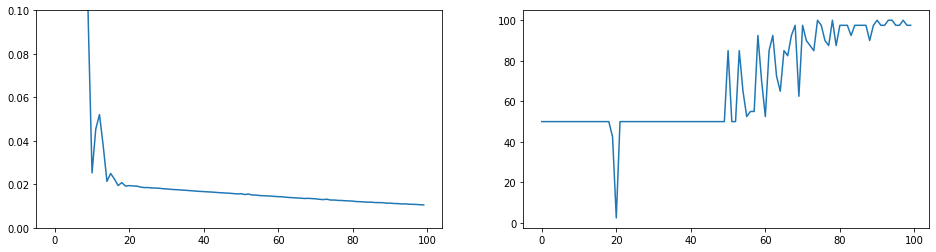

In [60]:
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(epoch_loss)
plt.ylim(0, 0.1)
plt.subplot(122)
plt.plot(valid_acc)

In [61]:
model2 = GenderNet(do_bn=True)
model2.to(device);

optimizer = torch.optim.SGD(model2.parameters(), lr=0.01, weight_decay=1e-3)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10, 20], 0.1)
criterion = nn.CrossEntropyLoss()

epoch_loss2 = []
valid_acc2 = []
for epoch in range(100):
    current_loss2, model2 = train(epoch, model2)
    valid_acc2.append(valid(epoch, model2))
    epoch_loss2.append(current_loss2)

GenderNet(
  (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=2, out_features=2, bias=True)
)
[1,     1] loss: 0.007
Accuracy on train set: 15.62% [5/32]
[1,     2] loss: 0.007
Accuracy on train set: 15.62% [10/64]
[1,     3] loss: 0.007
Accuracy on train set: 18.75% [18/96]
[1,     4] loss: 0.007
Accuracy on train set: 20.31% [26/128]
[1,     5] loss: 0.007
Accuracy on train set: 18.75% [30/160]
Validating...
----------------------------------------------------------------------------
Accuracy on valid set: 50.0% [20/40]
----------------------------------------------------------------------------
----------------------------------------------------------------------------
[2,     1] loss: 0.007
Accuracy on train set: 25.0% [8/32]
[2,     2] loss: 0.006
Accuracy on train set: 28.12% [18/64]
[2,     3] loss: 0.006
Accuracy on train set: 28.12% [27/96]
[2,     4] loss: 0.006
Accuracy on train set: 28.12% [36/128]
[2,     5] l

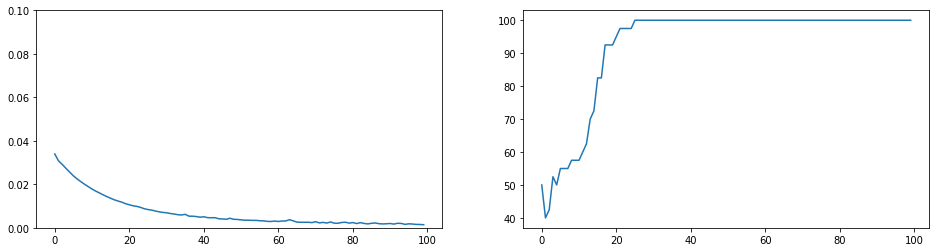

In [62]:
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(epoch_loss2)
plt.ylim(0, 0.1)
plt.subplot(122)
plt.plot(valid_acc2)

## 可见加入BN层收敛更快，准确率更高

In [54]:
bn = nn.BatchNorm1d(num_features=32)

In [55]:
data = train_set.data[[0, 1]].to_numpy()[:32]
data = torch.FloatTensor(data)
data = data.unsqueeze(0)
data.shape

torch.Size([1, 32, 2])

In [56]:
bn_data = bn(data)
bn_data.shape

torch.Size([1, 32, 2])

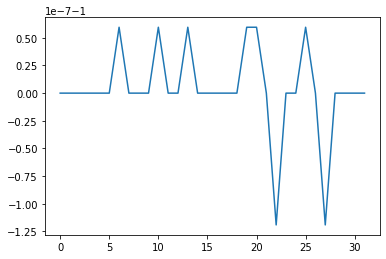

In [57]:
plt.plot(bn_data[0, :, 0].detach().numpy())

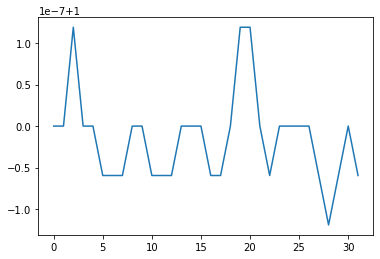

In [58]:
plt.plot(bn_data[0, :, 1].detach().numpy())